# Detecting Malicious URLs
## Baseline Experiments
### Understand Data
### Evaluate Some Traditional ML Algorithms

<a href="https://colab.research.google.com/github/rambasnet/DeepLearningMaliciousURLs/blob/master/Baseline-Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [5]:
from fastai.tabular import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
from sklearn.utils import shuffle
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.utils.multiclass import unique_labels

## Check CSV files inside FinalDataset folder
- if FinalDataset folder doesn't exist, download dataset using Baseline-Experiments.ipynb

In [5]:
! ls FinalDataset

All.csv                      Malware_Infogain_test.csv
All.csv.pickle               Phishing.csv
All_BestFirst.csv            Phishing_BestFirst.csv
All_BestFirst_test.csv       Phishing_Infogain.csv
All_Infogain.csv             Phishing_Infogain_test.csv
All_Infogain_test.csv        Spam.csv
Defacement.csv               Spam_BestFirst.csv
Defacement_BestFirst.csv     Spam_BestFirst_test.csv
Defacement_Infogain.csv      Spam_Infogain.csv
Defacement_Infogain_test.csv Spam_Infogain_test.csv
Malware.csv                  URL
Malware_BestFirst.csv        models
Malware_Infogain.csv


### note Notebook doesn't display all the rows and columns
- let's fix that

In [29]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [17]:
# class distribution for original data
print(df.groupby('URL_Type_obf_Type').size())

URL_Type_obf_Type
Defacement    7930
benign        7781
malware       6712
phishing      7586
spam          6698
dtype: int64


## Clean Data
- strip whitespace from column names
- dropped samples/rows with Infinity values
- dropped all columns with NaN values
- convert argPathRatio attribute type to float

In [6]:
def loadAndCleanData(csvFile):
    pickleDump = '{}DroppedNaNCols.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False)
        # clean data
        # strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col] == 'Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
            
        df.argPathRatio = df['argPathRatio'].astype('float')
        # drop all columns with NaN values
        beforeColumns = df.shape[1]
        df.dropna(axis='columns', inplace=True)
        print('Dropped {} columns with NaN values'.format(beforeColumns - df.shape[1]))
        # drop all rows with NaN values - sanity check
        beforeRows = df.shape[0]
        df.dropna(inplace=True)
        print('Dropped {} rows with NaN values'.format(beforeRows - df.shape[0]))
        df.to_pickle(pickleDump)
        
    return df

In [7]:
df1 = loadAndCleanData('FinalDataset/All.csv')

In [8]:
# sample distribution print in markdown table format
label = 'URL_Type_obf_Type'
lblTypes = set(df1[label])
for lbl in lblTypes:
    print('| {} | {} |'.format(lbl, len(df1[df1[label] == lbl].index)))

| benign | 7781 |
| phishing | 7577 |
| malware | 6711 |
| Defacement | 7930 |
| spam | 6698 |


In [9]:
df1.shape

(36697, 73)

## Evaluate Traditional ML Algorithms
- create a baseline model from a bunch of traditional ML algorithms
    - separate out a validation dataset
    - set-up test harness to use 10-fold cross-validation
    - build models to classify samples into various URL types
    - select the best model as our baseline model

### Create a Validation Dataset
- will be used to test our model to see how good it is!
- use 80/20 split
- 80% of samples used for training and 20% held back for validation

In [14]:
# Split-out validation dataset
def splitDataset(df):
    array = df.values
    X = array[:,0:72]
    Y = array[:,72]
    validation_size = 0.20
    random_seed = 100
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, 
                                                                                    test_size=validation_size, 
                                                                                    random_state=random_seed)
    return X_train, X_validation, Y_train, Y_validation
    

## Build & Evaluate Models

In [15]:
def runExperiments(X_train, Y_train):
    random_seed = 100
    scoring = 'accuracy'
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='auto')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('AB', AdaBoostClassifier(n_estimators=100)))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier(n_estimators=10)))

    # evaluate each model in turn using 10-fold cross-validation
    results = []
    classifiers = []
    accuracies = []
    for classifier, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=random_seed)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        accuracies.append((cv_results.mean(), classifier))
        results.append(cv_results)
        classifiers.append(classifier)
        msg = "%s: %f (%f)" % (classifier, cv_results.mean(), cv_results.std())
        print(msg)
    return results, accuracies, classifiers

## Multi-class Classification

In [16]:
# NOTE: This takes some time...
X_train, X_validation, Y_train, Y_validation = splitDataset(df1)
results, accuracies, classifiers = runExperiments(X_train, Y_train)

/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LR: 0.821882 (0.005276)


/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.


LDA: 0.766427 (0.006891)
KNN: 0.919577 (0.005682)
CART: 0.951970 (0.002135)
NB: 0.596451 (0.009623)
SVM: 0.914807 (0.003789)
AB: 0.665532 (0.021174)
DT: 0.951596 (0.001603)
RF: 0.969786 (0.003430)


## Compare and Select Best Model
- Compare Algorithms using box-plot

In [17]:
def compareModels(accuracies, results, classifiers):
    # sort the mean accuracy results in descending order and print
    accuracies.sort(reverse=True)
    for acc, cls in accuracies:
        print("{} {:.2f}".format(cls, acc))
    # Compare Algorithms using box-plot
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(classifiers)
    plt.show()

RF 0.97
CART 0.95
DT 0.95
KNN 0.92
SVM 0.91
LR 0.82
LDA 0.77
AB 0.67
NB 0.60


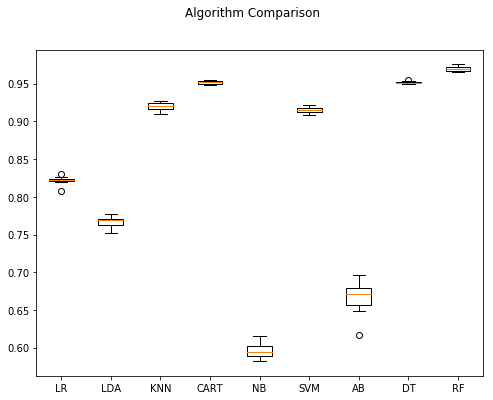

In [18]:
compareModels(accuracies, results, classifiers)

# Make Predictions using Random Forest (RF)
- RF provides superior accuracy result over all the classifiers
- now check the accuracy of the best model using validation set

In [19]:
def testBestModel(model, X_validation, Y_validation):
    # make predictions on validation dataset
    Y_predictions = rf.predict(X_validation)
    print("Accuracy = {:.2f}".format(accuracy_score(Y_validation, Y_predictions)))
    print('Confusion Matrix:')
    print(confusion_matrix(Y_validation, Y_predictions))
    print('Classification Report:')
    print(classification_report(Y_validation, Y_predictions))
    return Y_predictions

In [20]:
# train the best model and find the validation accuracy
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, Y_train)
Y_predictions = testBestModel(rf, X_validation, Y_validation)

Accuracy = 0.97
Confusion Matrix:
[[1569    1    0   24    0]
 [   2 1515    0   22    2]
 [   1   10 1339   14    3]
 [  21   32   17 1444    9]
 [  15    2    1   24 1273]]
Classification Report:
              precision    recall  f1-score   support

  Defacement       0.98      0.98      0.98      1594
      benign       0.97      0.98      0.98      1541
     malware       0.99      0.98      0.98      1367
    phishing       0.95      0.95      0.95      1523
        spam       0.99      0.97      0.98      1315

    accuracy                           0.97      7340
   macro avg       0.97      0.97      0.97      7340
weighted avg       0.97      0.97      0.97      7340



### Confusion Matrix Visualization

In [21]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


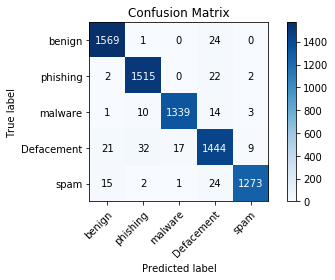

In [22]:
classes = lblTypes
np.set_printoptions(precision=2)
# plot non-normalized confusion matrix
plot_confusion_matrix(Y_validation, Y_predictions, classes=classes, 
                       title='Confusion Matrix')

## Binary-class classification
- Label spam, phishing, malware, defacement as 'malicious'
- Keep benign type as benign

In [23]:
lblTypes = list(lblTypes)
lblTypes

['benign', 'phishing', 'malware', 'Defacement', 'spam']

In [24]:
lblTypes = dict(zip(lblTypes, ['malicious']*5))
lblTypes['benign'] = 'benign'
lblTypes

{'benign': 'benign',
 'phishing': 'malicious',
 'malware': 'malicious',
 'Defacement': 'malicious',
 'spam': 'malicious'}

In [25]:
df1[label] = df1[label].map(lblTypes)

In [26]:
# class distribution for original data
print(df1.groupby('URL_Type_obf_Type').size())

URL_Type_obf_Type
benign        7781
malicious    28916
dtype: int64


In [27]:
df1.tail()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,tld,charcompvowels,charcompace,ldl_url,ldl_domain,...,NumberRate_FileName,SymbolCount_URL,SymbolCount_Domain,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,URL_Type_obf_Type
36702,29,4,14,5.750000,12,4,20,24,3,0,...,0.529412,19,3,11,3,2,7,0.690555,0.791265,malicious
36703,0,4,13,3.750000,8,4,24,23,0,0,...,0.187500,23,3,2,16,15,-1,0.665492,0.820010,malicious
36704,58,3,27,6.666666,16,3,41,34,20,0,...,0.377778,26,2,14,8,7,9,0.656807,0.801139,malicious
36705,35,3,13,4.333334,9,3,15,13,7,0,...,0.284091,14,2,1,9,8,3,0.725963,0.897617,malicious
36706,40,3,25,6.666666,16,3,35,31,19,0,...,0.365079,24,2,13,7,6,7,0.674351,0.801139,malicious


## Run Experiments to build Models

In [28]:
# NOTE: This takes a long time...
X_train, X_validation, Y_train, Y_validation = splitDataset(df1)
results, accuracies, classifiers = runExperiments(X_train, Y_train)

LR: 0.927104 (0.002662)


/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/rbasnet/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.


LDA: 0.910686 (0.002967)
KNN: 0.971182 (0.003257)
CART: 0.985182 (0.003603)
NB: 0.660899 (0.006267)
SVM: 0.963450 (0.002770)
AB: 0.969343 (0.002975)
DT: 0.984978 (0.003572)
RF: 0.989883 (0.001492)


## Compare and Select Best Model

RF 0.99
CART 0.99
DT 0.98
KNN 0.97
AB 0.97
SVM 0.96
LR 0.93
LDA 0.91
NB 0.66


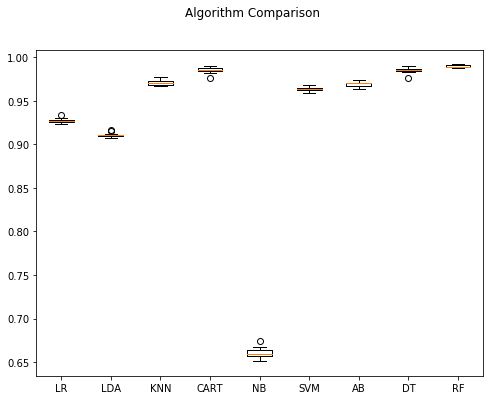

In [30]:
compareModels(accuracies, results, classifiers)

## Make Predictions using Best Classifier: Random Forest (RF)

In [31]:
# train the best model and find the validation accuracy
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, Y_train)
Y_predictions = testBestModel(rf, X_validation, Y_validation)

Accuracy = 0.99
Confusion Matrix:
[[1506   35]
 [  40 5759]]
Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.98      0.98      1541
   malicious       0.99      0.99      0.99      5799

    accuracy                           0.99      7340
   macro avg       0.98      0.99      0.98      7340
weighted avg       0.99      0.99      0.99      7340



### Confusion Matrix Viz

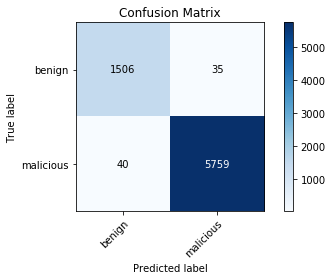

In [32]:
classes = ['benign', 'malicious']
np.set_printoptions(precision=2)
# plot non-normalized confusion matrix
plot_confusion_matrix(Y_validation, Y_predictions, classes=classes, 
                       title='Confusion Matrix')